# Проект по А/B-тестированию

## Описание проекта
Я являюсь аналитиком данных, моя задача провести оценку результатов A/B-теста согласно ТЗ.

Название теста: `recommender_system_test`
Группы: А (контрольная), B (новая платёжная воронка);

Дата запуска: 2020-12-07;

Дата остановки набора новых пользователей: 2020-12-21;

Дата остановки: 2021-01-04;

Аудитория: 15% новых пользователей из региона EU;

Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

Ожидаемое количество участников теста: 6000.

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

1. Конверсии в просмотр карточек товаров — событие product_page
2. Просмотры корзины — product_cart
3. Покупки — purchase.

## Описание данных

В моем распоряжение есть следующие датасеты: 

**`ab_project_marketing_events.csv`** - календарь маркетинговых событий на 2020 год. Состоит из:

1. `name` — название маркетингового события;
2. `regions` — регионы, в которых будет проводиться рекламная кампания;
3. `start_dt` — дата начала кампании;
4. `finish_dt` — дата завершения кампании.

**`final_ab_new_users.csv`** - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года. Состоит из:

1. `user_id` — идентификатор пользователя;
2. `first_date` — дата регистрации;
3. `region` — регион пользователя;
4. `device` — устройство, с которого происходила регистрация.

**`final_ab_events.csv`** - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года. Состоит из:
1. `user_id` — идентификатор пользователя;
2. `event_dt` — дата и время события;
3. `event_name` — тип события;
4. `details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

**`final_ab_participants.csv`** - таблица участников тестов. Состоит из:

1. `user_id` — идентификатор пользователя;
2. `ab_test` — название теста;
3. `group` — группа пользователя.

## Цели исследования

Оценить корректность проведения теста и проанализировать его результаты.

Чтобы оценить корректность проведения теста:
1. Удостоверюсь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
2. Проверю равномерность распределения пользователей по тестовым группам и правильность их формирования.

  


## План работы
1. Изучу предоставленные данные. Корректно ли в них типы данных, есть или нет пропусков и дубликатов, дам свою оценку по результатам.
2. Оценю корректность проведения теста c помощью предоставленных данных:
    - Соответствие данных требованиям технического задания. Проверю корректность всех пунктов технического задания.
    - Время проведения теста. Проверю, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Удостоверюсь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверю равномерность распределения пользователей по тестовым группам и правильность их формирования.
3. Проведу исследовательский анализ данных:
    - Количество событий на пользователя одинаково распределены в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
4. Проведу оценку результатов A/B-тестирования:
    - Анализ результатов
    - Проверка статистическую разницу долей z-критерием.
5. Вывод по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделаю общее заключение о корректности проведения теста.  

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

In [2]:
try:
    marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
except:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
    events = pd.read_csv('final_ab_events.csv')
    new_users = pd.read_csv('final_ab_new_users.csv')
    participants = pd.read_csv('final_ab_participants.csv')

In [3]:
display(marketing_events)
marketing_events.info()
print("Количество дубликатов в датасете:", marketing_events.duplicated().sum() )

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes
Количество дубликатов в датасете: 0


Итак, предоставленные данные уже **некорректны** - столбцы с датами не в том формате. Исправлю.

In [4]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] =pd.to_datetime(marketing_events['finish_dt'])
display(marketing_events)
marketing_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes


In [5]:
display(events)
events.info()
print("Количество дубликатов в датасете:", events.duplicated().sum() )

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
Количество дубликатов в датасете: 0


Два момента - `event_dt` не в том формате, в `details` есть пропуски.

In [6]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
display(events[events['details'].isnull()])
display(events[events['details'].notnull()])
print('Следующие события имеют данные в в деталях:', events[events['details'].notnull()]['event_name'].unique())

,user_id,event_dt,event_name,details
62740,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
62741,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
62742,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
62743,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
62744,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
62735,1455450835F72F5E,2020-12-30 09:27:10,purchase,4.99
62736,339C4C55021A83C6,2020-12-30 12:55:08,purchase,9.99
62737,D1553B56FFA8974B,2020-12-30 03:15:35,purchase,4.99
62738,245E85F65C358E08,2020-12-30 19:35:55,purchase,9.99


Следующие события имеют данные в в деталях: ['purchase']


**Подтверждаю** данные из ТЗ - в `details` пропуски не имеют только те строки, которые обозначают строки с покупкой. В остальных случаях деталей нет.

**Некорректно** - проблема с типом данных, исправил.


In [7]:
display(new_users)
new_users.info()
print("Количество дубликатов в датасете:", new_users.duplicated().sum() )

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
Количество дубликатов в датасете: 0


In [8]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

Вновь **некорректен** вид данных.

In [9]:
display(participants)
participants.info()
print("Количество дубликатов в датасете:", participants.duplicated().sum() )


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
Количество дубликатов в датасете: 0


В данном датасете все верно. Однако видно, что в нем есть как минимум два теста.

In [10]:
print('В датасете присутствуют следующие тесты:', participants['ab_test'].unique())

В датасете присутствуют следующие тесты: ['recommender_system_test' 'interface_eu_test']


В ТЗ стоит задача исследовать `recommender_system_test`. В рамках нашего исследования группа `interface_eu_test` мне не нужна. Для начала проверю, есть ли пользователи, которые в рамках одного теста состоят в двух группах.

In [11]:
recommender_system_test_users = participants[participants['ab_test'] == 'recommender_system_test']
user_group_counts_recommender = recommender_system_test_users.groupby('user_id')['group'].nunique()
users_in_both_groups_recommender = user_group_counts_recommender[user_group_counts_recommender == 2].index
users_in_both_groups_info_recommender = recommender_system_test_users[recommender_system_test_users['user_id'].isin(users_in_both_groups_recommender)]
print("Пользователи в обеих группах теста recommender_system_test:")
print(users_in_both_groups_info_recommender)


interface_eu_test_users = participants[participants['ab_test'] == 'interface_eu_test']
user_group_counts_interface = interface_eu_test_users.groupby('user_id')['group'].nunique()
users_in_both_groups_interface = user_group_counts_interface[user_group_counts_interface == 2].index
users_in_both_groups_info_interface = interface_eu_test_users[interface_eu_test_users['user_id'].isin(users_in_both_groups_interface)]
print("\nПользователи в обеих группах теста interface_eu_test:")
print(users_in_both_groups_info_interface)


Пользователи в обеих группах теста recommender_system_test:
Empty DataFrame
Columns: [user_id, group, ab_test]
Index: []

Пользователи в обеих группах теста interface_eu_test:
Empty DataFrame
Columns: [user_id, group, ab_test]
Index: []


Итак, у нас нет пользователей, которые участвуют в двух группах в рамках одно теста.

Теперь подсчитаю количество пользователей, которые участвуют в двух тестах сразу.


In [17]:
group_a = participants[participants['group'] == 'A']

group_b = participants[participants['group'] == 'B']

duplicates_a = group_a[group_a.duplicated(subset=['user_id'], keep=False)]
duplicates_b = group_b[group_b.duplicated(subset=['user_id'], keep=False)]

print("Дубликаты тестов в группе A:")
display(duplicates_a)

print("\nДубликаты тестов в группе B:")
display(duplicates_b)

Дубликаты тестов в группе A:


,user_id,group,ab_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
10,B3A2485649E4A012,A,recommender_system_test
31,D6E62099519F986C,A,recommender_system_test
33,0F1FF07B3788976D,A,recommender_system_test
...,...,...,...
18099,E14500C7172C0D15,A,interface_eu_test
18137,041ED985CA4223B3,A,interface_eu_test
18148,C7D1A5A6F6BAD476,A,interface_eu_test
18210,70BF82527E6ED9C3,A,interface_eu_test



Дубликаты тестов в группе B:


,user_id,group,ab_test
29,5D5E6EE92AF6E9E0,B,recommender_system_test
53,952D1EEBF552BC95,B,recommender_system_test
79,B3C1FF8D21EAC16B,B,recommender_system_test
105,04BE4EFE4C457312,B,recommender_system_test
124,A0794039D643F1B6,B,recommender_system_test
...,...,...,...
18079,8FF8F87305BB9A7D,B,interface_eu_test
18094,C2025648F77BD80B,B,interface_eu_test
18170,7DF21AEB1AA231F9,B,interface_eu_test
18183,EA6EA431FF84563B,B,interface_eu_test


In [23]:
print("Общее количество уникальных пользователей:", participants['user_id'].nunique())
print("Количество пользователей, участвующих в обеих группах (A и B) в обоих тестах:",  duplicates_a['user_id'].nunique() +  duplicates_b['user_id'].nunique())
print('Доля пользователей: {:.2f}%'.format((duplicates_a['user_id'].nunique() +  duplicates_b['user_id'].nunique()) / participants['user_id'].nunique() * 100))


Общее количество уникальных пользователей: 16666
Количество пользователей, участвующих в обеих группах (A и B) в обоих тестах: 826
Доля пользователей: 4.96%


Доля граничит с пределом по удалению данных. Известно, что группа А включает в себя пользователей контрольной группы, а значит без изменений. Что бы не удалять всех пользователей, которые участвовали в обоих тестах, можно убрать только тех, которое в обоих тестах были в группе В.

In [24]:
print("Количество пользователей, участвующих в обоих тестах:",    duplicates_b['user_id'].nunique())
print('Доля пользователей: {:.2f}%'.format((  duplicates_b['user_id'].nunique()) / participants['user_id'].nunique() * 100))


Количество пользователей, участвующих в обоих тестах: 344
Доля пользователей: 2.06%


Доля пользователей составляет всего два процента цента, можно убрать без искажения данных.

In [25]:
group_b_eu= participants[participants['ab_test'] == 'interface_eu_test']
group_b_eu = group_b_eu[group_b_eu['group'] == 'B']
group_b_eu

,user_id,group,ab_test
6705,2BA8FA8754D1FE50,B,interface_eu_test
6706,FB6F6BC119E1DBD5,B,interface_eu_test
6707,2D2E7AA539CF348F,B,interface_eu_test
6709,76B6CDF2A8B1DBFC,B,interface_eu_test
6712,10DAD07E71B44F26,B,interface_eu_test
...,...,...,...
18254,06CB5B54FDFEA69F,B,interface_eu_test
18260,60A2B3B987457ECE,B,interface_eu_test
18262,4155D795096E6CFE,B,interface_eu_test
18263,1D302F8688B91781,B,interface_eu_test


In [26]:
group_b_eu = group_b_eu['user_id']
group_a_users = group_a['user_id']
common_users = group_b_eu[group_b_eu.isin(group_a_users)]
display(group_b_eu)
print('----------------')
display(group_a_users)

6705     2BA8FA8754D1FE50
6706     FB6F6BC119E1DBD5
6707     2D2E7AA539CF348F
6709     76B6CDF2A8B1DBFC
6712     10DAD07E71B44F26
               ...       
18254    06CB5B54FDFEA69F
18260    60A2B3B987457ECE
18262    4155D795096E6CFE
18263    1D302F8688B91781
18267    79F9ABFB029CF724
Name: user_id, Length: 5736, dtype: object

----------------


0        D1ABA3E2887B6A73
1        A7A3664BD6242119
2        DABC14FDDFADD29E
3        04988C5DF189632E
5        4FF2998A348C484F
               ...       
18259    96304D5B53694096
18261    A1281767A2983E4D
18264    3DE51B726983B657
18265    F501F79D332BE86C
18266    63FBE257B05F2245
Name: user_id, Length: 9655, dtype: object

In [28]:
set_group_b_eu = set(group_b_eu)
set_group_a_users = set(group_a_users)

intersection_users = set_group_b_eu.intersection(set_group_a_users)

if len(intersection_users) > 0:
    print("Есть пересечение пользователей между group_b_eu и group_a_users.")
else:
    print("Нет пересечения пользователей между group_b_eu и group_a_users.")
intersection_df = group_a[group_a['user_id'].isin(intersection_users)]

display(intersection_df)

Есть пересечение пользователей между group_b_eu и group_a_users.


,user_id,group,ab_test
44,FC3F3E4DA7C85F88,A,recommender_system_test
49,FE2AF0E94DBD470E,A,recommender_system_test
60,C5AD06762E628169,A,recommender_system_test
104,25CE0629AC6B6971,A,recommender_system_test
129,44EB15AD423DC31C,A,recommender_system_test
...,...,...,...
6302,D7933558E33BF7D5,A,recommender_system_test
6304,DECA5C05A77980A1,A,recommender_system_test
6305,32164CC8F884B9A5,A,recommender_system_test
6309,7FE6DDDB6C85C934,A,recommender_system_test


In [29]:
a_b_rec = participants[participants['ab_test'] == 'recommender_system_test']
a_b_rec = a_b_rec[~a_b_rec['user_id'].isin(duplicates_b['user_id'])]
a_b_rec = a_b_rec[~a_b_rec['user_id'].isin(intersection_df['user_id'])]

In [30]:
display(a_b_rec)
a_b_rec.info()
print("Количество дубликатов в датасете:", a_b_rec.duplicated().sum() )

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5918 non-null   object
 1   group    5918 non-null   object
 2   ab_test  5918 non-null   object
dtypes: object(3)
memory usage: 184.9+ KB
Количество дубликатов в датасете: 0


In [31]:
print("Пользователи, которые находятся в обеих группах:", a_b_rec[a_b_rec.duplicated(subset='user_id', keep=False)])

Пользователи, которые находятся в обеих группах: Empty DataFrame
Columns: [user_id, group, ab_test]
Index: []


Создаем единый датафрейм с информацией о пользователях.

In [32]:
a_b_rec = a_b_rec.merge(new_users, on = 'user_id', how = 'inner')
display(a_b_rec)
a_b_rec.info()
print("Количество дубликатов в датасете:", a_b_rec.duplicated().sum() )



,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
...,...,...,...,...,...,...
5913,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android
5914,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac
5915,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac
5916,29C92313A98B1176,B,recommender_system_test,2020-12-07,APAC,Android


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918 entries, 0 to 5917
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     5918 non-null   object        
 1   group       5918 non-null   object        
 2   ab_test     5918 non-null   object        
 3   first_date  5918 non-null   datetime64[ns]
 4   region      5918 non-null   object        
 5   device      5918 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 323.6+ KB
Количество дубликатов в датасете: 0


In [33]:
a_b_rec = a_b_rec.merge(events, on = 'user_id', how = 'inner')
display(a_b_rec)
a_b_rec.info()
print("Количество дубликатов в датасете:", a_b_rec.duplicated().sum())


,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
21837,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,login,NaN
21838,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,login,NaN
21839,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,login,NaN
21840,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,login,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21842 entries, 0 to 21841
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21842 non-null  object        
 1   group       21842 non-null  object        
 2   ab_test     21842 non-null  object        
 3   first_date  21842 non-null  datetime64[ns]
 4   region      21842 non-null  object        
 5   device      21842 non-null  object        
 6   event_dt    21842 non-null  datetime64[ns]
 7   event_name  21842 non-null  object        
 8   details     2939 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.7+ MB
Количество дубликатов в датасете: 0


### Вывод
Как итог у нас есть два датасета:
`marketing_events` - представляет из себя набор маркетинговых кампаний.

`a_b_rec` - все данные о пользователях, которые участвуют исключительно в нужном тесте.

Я проверил датасеты на отсутствие дубликатов, убедился, что пропуски в них обоснованы, дубликаты отсутствуют. Можно приступать к следующему этапу.


## Оценю корректность проведения теста c помощью предоставленных данных

Для начала вновь обращусь к ТЗ

Название теста: `recommender_system_test;`
Группы: А (контрольная), B (новая платёжная воронка);

Дата запуска: 2020-12-07;

Дата остановки набора новых пользователей: 2020-12-21;

Дата остановки: 2021-01-04;

Аудитория: 15% новых пользователей из региона EU;

Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

Ожидаемое количество участников теста: 6000.

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

1. Конверсии в просмотр карточек товаров — событие product_page
2. Просмотры корзины — product_cart
3. Покупки — purchase.

Чуть выше я отобрал исключительно участников нужного теста, теперь из было 6701 участник. Буду исследовать по каждому пункту.

Начну с временных рамок. 



### Анализ временных промежутков. 
Тест был запущен 7 декабря, значит нам не нужны пользователи, которые пришли раньше. Проверим

In [34]:
print('Наиболее ранняя дата регистрации:', a_b_rec['first_date'].min())
print('Наиболее поздняя дата регистрации', a_b_rec['first_date'].max())
print ('наиболее ранее событие произошло', a_b_rec['event_dt'].min())
print ('наиболее позднее событие произошло',a_b_rec['event_dt'].max()) 

Наиболее ранняя дата регистрации: 2020-12-07 00:00:00
Наиболее поздняя дата регистрации 2020-12-21 00:00:00
наиболее ранее событие произошло 2020-12-07 00:05:57
наиболее позднее событие произошло 2020-12-30 12:42:57


**Корректно** - дата регистрации, все пользователи в базе зарегистрировались с момента начала теста. Закончилась регистрация так же согласно предоставленной информации и до окончания теста.

**Некорректно** -Тест остановился 1 января, однако последние действия произошли 30 декабря. Это означает, что как минимум последняя когорта пользователей будет изучена всего на 1 неделю, что может сказаться на исследовании.  Например, во праздничных дней пользователи стали использовать сервис чаще, но мы не узнаем - повлиял ли Новый год на пользователей. 



Проверим время проведения маркетинговых кампаний. Согласно ТЗ нас интересуют пользователи EU.


In [26]:
display(marketing_events[marketing_events['regions'].str.contains('EU')])

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10


`Christmas & New Year Promo` происходила в момент проведения теста, при этом затрагивала необходимый нам регион. При этом ранее было обозначено, что последние события фиксируются 30 декабря. То есть с одной стороны есть влияние на аудиторию, с другой полноценно его проверить не получится.



### Проверка аудитории

Согласно ТЗ нам необходимы 15% пользователей из региона EU

Для начала проверим, какие есть регионы в датасете.


In [35]:
print('В датасете присутствуют следующие регионы:', a_b_rec['region'].unique())

В датасете присутствуют следующие регионы: ['EU' 'N.America' 'APAC' 'CIS']


Как можно увидеть, в самом дататесте, а значит и в тестировании, принимали участия пользователи из нескольких регионов. Для проведения тестирования нам нужна определенная аудитория


In [36]:
display(a_b_rec)
a_b_rec.info()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
21837,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,login,NaN
21838,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,login,NaN
21839,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,login,NaN
21840,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,login,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21842 entries, 0 to 21841
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21842 non-null  object        
 1   group       21842 non-null  object        
 2   ab_test     21842 non-null  object        
 3   first_date  21842 non-null  datetime64[ns]
 4   region      21842 non-null  object        
 5   device      21842 non-null  object        
 6   event_dt    21842 non-null  datetime64[ns]
 7   event_name  21842 non-null  object        
 8   details     2939 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.7+ MB


In [37]:
a_b_rec = a_b_rec[a_b_rec['region'] == 'EU']
display(a_b_rec)
a_b_rec.info()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
...,...,...,...,...,...,...,...,...,...
20559,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:06,product_page,NaN
20560,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-20 20:01:34,product_page,NaN
20561,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-14 05:48:50,login,NaN
20562,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:03,login,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20564 entries, 0 to 20563
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     20564 non-null  object        
 1   group       20564 non-null  object        
 2   ab_test     20564 non-null  object        
 3   first_date  20564 non-null  datetime64[ns]
 4   region      20564 non-null  object        
 5   device      20564 non-null  object        
 6   event_dt    20564 non-null  datetime64[ns]
 7   event_name  20564 non-null  object        
 8   details     2804 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.6+ MB


В ТЗ указано, что аудитория это 15% от новых пользователей из региона. Согласно описанию данных, в датасете с пользователями были записаны **все пользователи**, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года. 
Ожидаемая аудитория пользователей - 6000 участников.


In [38]:
print("Количество уникальных пользователей:", a_b_rec['user_id'].nunique())

Количество уникальных пользователей: 3050


In [39]:
a_b_rec_all = new_users
a_b_rec_all = a_b_rec_all.merge(events, on = 'user_id', how = 'inner') 
a_b_rec_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440317 entries, 0 to 440316
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   first_date  440317 non-null  datetime64[ns]
 2   region      440317 non-null  object        
 3   device      440317 non-null  object        
 4   event_dt    440317 non-null  datetime64[ns]
 5   event_name  440317 non-null  object        
 6   details     62740 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 26.9+ MB


In [40]:
a_b_rec_all = a_b_rec_all[a_b_rec_all['first_date'] <= '2020-12-21']

In [41]:
print('Наиболее ранняя дата регистрации:', a_b_rec_all['first_date'].min())
print('Наиболее поздняя дата регистрации', a_b_rec_all['first_date'].max())
print ('наиболее ранее событие произошло', a_b_rec_all['event_dt'].min())
print ('наиболее позднее событие произошло',a_b_rec_all['event_dt'].max()) 

Наиболее ранняя дата регистрации: 2020-12-07 00:00:00
Наиболее поздняя дата регистрации 2020-12-21 00:00:00
наиболее ранее событие произошло 2020-12-07 00:00:33
наиболее позднее событие произошло 2020-12-30 23:36:33


In [42]:
print('Доля пользователей из EU составляет в изначальном датасете:', round(a_b_rec['user_id'].nunique() / a_b_rec_all[a_b_rec_all['region'] == 'EU']['user_id'].nunique() * 100, 2), '%')

Доля пользователей из EU составляет в изначальном датасете: 7.73 %


In [43]:
a_b_rec_all[a_b_rec_all['region'] == 'EU']['user_id'].nunique()

39466

Доля не соответствует ТЗ - 7.73

Проверю распределение групп в тз. 

In [44]:
users_group = a_b_rec.loc[:, ["user_id", "group"]]
users_group = users_group.drop_duplicates() 
group_counts = users_group['group'].value_counts()

count_A = group_counts.get('A', 0)
count_B = group_counts.get('B', 0)

total_rows = len(users_group)

ratio_A = count_A / total_rows
ratio_B = count_B / total_rows

# Форматируем вывод для удобочитаемости.
output = f"Соотношение группы A и группы B к общему количеству составляет: {ratio_A:.2%} и {ratio_B:.2%} соответственно."
print(group_counts)
# Выводим результат.
print(output)

A    2279
B     771
Name: group, dtype: int64
Соотношение группы A и группы B к общему количеству составляет: 74.72% и 25.28% соответственно.


Как можно увидеть, распределение групп крайне **неравномерно**, разница почти в 3 раза. 

Согласно ТЗ, ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%. Для этого отфильтруем пользователей, пользовавшихся сервисом меньше двух недель.

In [45]:
a_b_rec['day_event_dt'] = a_b_rec['event_dt'].dt.date
a_b_rec['day_event_dt'] = pd.to_datetime(a_b_rec['day_event_dt'])
a_b_rec['dt_delta'] = a_b_rec['day_event_dt'] - a_b_rec['first_date']
a_b_rec = a_b_rec[a_b_rec['dt_delta'] <= pd.Timedelta(days=14)]
a_b_rec

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,day_event_dt,dt_delta
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,0 days
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,0 days
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07,0 days
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,2020-12-07,0 days
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,2020-12-20,0 days
...,...,...,...,...,...,...,...,...,...,...,...
20559,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:06,product_page,NaN,2020-12-15,1 days
20560,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-20 20:01:34,product_page,NaN,2020-12-20,6 days
20561,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-14 05:48:50,login,NaN,2020-12-14,0 days
20562,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:03,login,NaN,2020-12-15,1 days


### Вывод

При формировании групп согласно ТЗ нарушены множество пунктов:
1. В датасете отсутствуют события с 31 декабря и до окончания теста.
2. В тестировании принимали участия не только пользователи из Европы.
3. Общее число пользователей из Европы не соответствуют запланированному в ТЗ. Уменьшать его до 15% ухудшит ситуацию.
4. Группы распределены неравномерно. При допущении в отклонении на 1-2% я вижу, что группа В меньше практически в 3 раза. 

Все это являются крайне ошибочными вводными для проведения тестирования.


## Исследовательский анализ данных

Для начала изучу количество событий на пользователя в двух выборках.

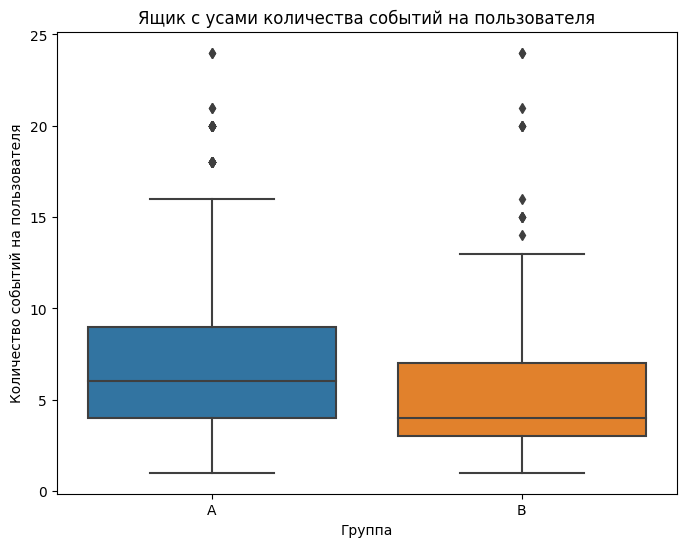

In [46]:
events_per_user = a_b_rec.groupby(['group', 'user_id'])['event_name'].count().reset_index()

# Построим ящики с усами для каждой группы.
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='event_name', data=events_per_user)
plt.title('Ящик с усами количества событий на пользователя')
plt.xlabel('Группа')
plt.ylabel('Количество событий на пользователя')
plt.show()

Как можно увидеть, контрольная группа совершала больше действий. Медианное значение 6 против 4.

Изучим как распределялись события по дням.



In [48]:
events_count = a_b_rec.groupby('day_event_dt')['event_name'].count().reset_index().rename(columns={'day_event_dt': 'day', 'event_name': 'count'})

fig = px.bar(events_count, 
             y='count', 
             x= 'day', 
             title = 'Действите пользователей по дням' 
             )
fig.update_layout(yaxis_title = 'Количество действий',
                 xaxis_title = 'Дата'
                 )
fig.update_xaxes(tickangle=45)
fig.update_traces(hovertemplate = 'День : %{x} <br>Количество: %{y}')

fig.show()

Можно замтетить уже с 14 декабря виден большой всплеск интереса пользователей.

In [52]:
events_count_by_group = a_b_rec.groupby(['day_event_dt','group'])['event_name'].count().reset_index().rename(columns={'day_event_dt': 'day', 'event_name': 'count'})
fig = px.bar(events_count_by_group, 
             y='count', 
             x= 'day', 
             title = 'Количество действий в день погруппам', 
             color = 'group', barmode='group')
fig.update_layout(yaxis_title = 'Количество действий',
                 xaxis_title = 'Дата'
                 )
fig.update_xaxes(tickangle=45)
fig.update_traces(hovertemplate = 'День : %{x} <br>Количество: %{y}')

fig.show()

Я вижу колоссальную разницу в действиях, но связываю её именно с катастрофичной для теста разницей в количестве респондентов. Но в целом можно отметить, что плюс минус распределение одинаковое, хотя если в группе А 16 по 20 декабря шел плавный рост, то в группе В было был спад и небольшой подъем. 
Для улучшения понимания картины, посчитаю действия в долях от действий по группам


In [54]:
actions_per_day = a_b_rec.groupby(['group', 'day_event_dt'])['event_name'].count().reset_index()
actions_per_group = actions_per_day.groupby('group')['event_name'].sum().reset_index()
actions_per_day = actions_per_day.merge(actions_per_group, on='group', suffixes=('', '_total'))
actions_per_day['action_ratio'] = actions_per_day['event_name'] / actions_per_day['event_name_total']

fig = px.line(actions_per_day, x='day_event_dt', y='action_ratio', color='group',
              title='Доли действий пользователей по дням от общего количества действий по группам',
              labels={'day_event_dt': 'Дата', 'action_ratio': 'Доля действий'},
              template='plotly_white')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

Вцелом подтверждаются вывод, которые обозначены ранее.  

In [55]:
registration_per_day = a_b_rec.groupby(['group', 'first_date'])['user_id'].nunique().reset_index()

fig = px.bar(registration_per_day, x='first_date', y='user_id', color='group',
             title='Регистрация пользователей по группам',
             labels={'first_date': 'Дата регистрации', 'user_id': 'Количество зарегистрированных пользователей'},
             template='plotly_white')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [56]:
users_per_group = a_b_rec.groupby('group')['user_id'].nunique().reset_index()
users_per_group.columns = ['group', 'total_users']

registration_per_day = a_b_rec.groupby(['group', 'first_date'])['user_id'].nunique().reset_index()
registration_per_day.columns = ['group', 'first_date', 'registered_users']

registration_per_day = pd.merge(registration_per_day, users_per_group, on='group', how='left')

registration_per_day['percentage'] = (registration_per_day['registered_users'] / registration_per_day['total_users']) * 100

fig = px.line(registration_per_day, x='first_date', y='percentage', color='group',
              title='Распределение регистрации пользователей в процентном соотношении',
              labels={'first_date': 'Дата регистрации', 'percentage': 'Доля зарегистрированных пользователей (%)'},
              template='plotly_white')

fig.update_layout(xaxis_tickangle=-45)
fig.show()


Аналогично вижу, что с момента начала рекламной кампании количество пользователей растет. 

Отвечу на вопрос относительно конверсии в воронках на каждом этапе.


In [57]:
a_b_rec.event_name.value_counts()

login           9054
product_page    5588
purchase        2736
product_cart    2656
Name: event_name, dtype: int64

Скорее всего логика такая. Пользователь совершает `login` -> `product_page` -> `product_cart` >  `purchase`. Уже сейчас можно заметить, что огромное количество пользователей не переходит дальше этапа авторизации. Возникает вопрос почему? 

Предполагаю, что либо сервис не сохраняет данные о входе и пользователям необходимо повторно авторизовываться, либо они не находят нужное предложение.  Больше склоняюсь ко второму варианту, так как в первом случае количество хотя бы просмотров предложений должно было быть больше, чем авторизаций. Так же отмечу, что событий оплаты происходит больше, чем перехода в корзину. Возможно, имеется такая возможность в функционале.


In [58]:
events_count = a_b_rec.groupby('event_name').agg({'user_id':'nunique'}).reset_index()
events_count = events_count.sort_values(by='user_id', ascending=False)
events_count = events_count.reset_index(drop=True)


events_count = events_count.reindex([0, 1, 3, 2])
events_count = events_count.reset_index(drop=True)
events_count

,event_name,user_id
0,login,3049
1,product_page,1905
2,product_cart,900
3,purchase,953


events_count = events_count.sort_values(by='user_id', ascending=False)
events_count = events_count.reset_index(drop=True)
events_count

In [59]:
fig = go.Figure(go.Funnel(y = events_count['event_name'], x = events_count['user_id'], textinfo = "value+percent initial+percent previous"))
fig.update_layout(title="Воронка событий пользователей", width=1000, height=700)
fig.show();

В целом можно сказать, что   половина пользователей, дошли до целевого события - факта оплаты, что хороший результат. А теперь посмотрим распределение по группам.

In [60]:
group_events_count = a_b_rec.groupby(['event_name','group']).agg({'user_id':'nunique'}).reset_index()
group_events_count = group_events_count.sort_values(by='group')
group_events_count


event_order = ["login", "product_page", "product_cart", "purchase"]

group_events_count['event_name'] = pd.Categorical(group_events_count['event_name'], categories=event_order, ordered=True)
group_events_count = group_events_count.sort_values(by=['group', 'event_name']).reset_index(drop=True)

display(group_events_count)


,event_name,group,user_id
0,login,A,2279
1,product_page,A,1476
2,product_cart,A,686
3,purchase,A,734
4,login,B,770
5,product_page,B,429
6,product_cart,B,214
7,purchase,B,219


In [61]:
import plotly.graph_objects as go

groups = ['A', 'B']
fig = go.Figure()

for i, group in enumerate(groups):
    fig.add_trace(go.Funnel(
        name=group,
        y=(group_events_count[(group_events_count['group'] == group)]['event_name']),
        x=(group_events_count[(group_events_count['group'] == group)]['user_id']),
        textposition="inside",
        textinfo="text+percent initial+percent previous",
        insidetextfont={'color': 'white'},
    ))

fig.update_layout(title="Воронка событий пользователей в группах", width=1000, height=800)
fig.show()


В целом происходит интересная тенденция. Мое предположение о невозможности найти нужный товар кажется менее правдоподобной, теперь я склоняюсь к тому, что у участников теста возникли проблемы с логином. Стоит уточнить у тех службы компании, возникали ли проблемы с данной операцией у пользователей данной группы.

### Вывод

1. Необходимо учитывать, что у нас отсутствуют данные после 30 декабря, что негативно сказывается на исследовании.
2. В период проведения теста проводилась маркетинговая компания, что может так же исказить тестирование.
3. С 14 декабря наблюдается рост активности пользователей, скорее всего из-за п.2.
4. В процентном соотношении группа А имеет лучшие показатели как по количеству действий, так и по количеству регистраций в день.
5. Возможно есть проблемы с входом в систему. 

**Важный ответ на ТЗ**

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.

Согласно воронкам эффекта не произошло


## Тестирование

In [62]:
all_groups = a_b_rec.groupby(['group', 'event_name']).agg({'user_id': 'nunique'}).reset_index()
all_groups

,group,event_name,user_id
0,A,login,2279
1,A,product_cart,686
2,A,product_page,1476
3,A,purchase,734
4,B,login,770
5,B,product_cart,214
6,B,product_page,429
7,B,purchase,219


In [63]:
df_count_group = a_b_rec.groupby('group')['user_id'].nunique().reset_index()
df_count_group

,group,user_id
0,A,2279
1,B,771


*Отмечу странный факт, количество пользователей всего в группе В на 1 больше чем тех, кто совершил вход в сервис. Возможно 1 человек после регистрации на сайте отвлекся от сервиса и больше к нему не возвращался.*


Сформулирую гипотезы:

`H0` - Количество пользователей, совершивших событие в группах А и В статистически равно.

`H1` - Количество пользователей, совершивших событие в группах А и В статистически отличается.

Ввиду проверки сразу трех тестов, использую поправку Бонферрони

> Простейший из методов множественного сравнения — введение поправки Бонферрони. Которая гласит, что если мы хотим обеспечить вероятность ошибки α′, то в каждом из сравнений мы должны принять уровень значимости α′/k — это и есть поправка Бонферрони. Например, при трехкратном сравнении уровень значимости должен быть 0,05/3= 1,7%. Поправка Бонферрони хорошо работает, если число сравнений невелико.

0.05/3 = 0.017


In [64]:
def z_test(exp1, exp2, event, alpha):
    p1_ev = all_groups[(all_groups['group'] == exp1) & (all_groups['event_name'] == event)]['user_id'].values[0]
    p2_ev = all_groups[(all_groups['group'] == exp2) & (all_groups['event_name'] == event)]['user_id'].values[0]
    
    p1_us = df_count_group[df_count_group['group'] == exp1]['user_id'].values[0]
    p2_us = df_count_group[df_count_group['group'] == exp2]['user_id'].values[0]
    
    print(p1_ev, p2_ev, p1_us, p2_us)
    
    p1 = p1_ev / p1_us
    p2 = p2_ev / p2_us
    
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us)
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Проверка для {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
        print("Среднее количество пользователей совершивших {} в группах A и B статистически различается".format(event))
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
        print("Среднее количество пользователей совершивших {} в группах A и B статистически не различается".format(event))



In [65]:
z_test('A', 'B', 'product_page', alpha=0.017)

1476 429 2279 771
Проверка для A и B, событие: product_page, p-значение: 0.00
Отвергаем нулевую гипотезу
Среднее количество пользователей совершивших product_page в группах A и B статистически различается


In [66]:
z_test('A', 'B', 'product_cart', alpha=0.017)

686 214 2279 771
Проверка для A и B, событие: product_cart, p-значение: 0.22
Не получилось отвергнуть нулевую гипотезу
Среднее количество пользователей совершивших product_cart в группах A и B статистически не различается


In [67]:
z_test('A', 'B', 'purchase', alpha=0.017)

734 219 2279 771
Проверка для A и B, событие: purchase, p-значение: 0.05
Не получилось отвергнуть нулевую гипотезу
Среднее количество пользователей совершивших purchase в группах A и B статистически не различается


Согласно тестированию, количество пользователей, которые зашли на карточку товара различается, но остальные два действия одинаковы.

# Общий итог исследования

Можно с уверенностью сказать, что данные не подходят для проведения тестирования. Присутствуют следующие ошибки:

1. Отсутствуют данные о действиях после 30.12.2020.
2. Количество пользователей менее 6000.
3. В период проведения теста Christmas&New Year Promo, которая затронуло целевую группу.
4. Доли участников не соответствуют А и В тестированию - практически 75% в группе А и 25% в группе В.
5. Количество участников не соответствует требуемым 15%.

Цель "увеличение показателей на 10%" не достигнута.

А\В тестирование показало, что изменения в группе В не повлияли на действия пользователей кроме просмотра продуктовых карт.

Можно сказать, что на результаты теста ориентироваться нельзя. Необходимо вернуть датасеты заказчику, уточнить актуальны ли они и нет ли проблем с выгрузкой. Если датасеты актуальны, требуется заново провести тестирование с учетом ошибок. Если нет, то заново провести анализ с новыми датасетами.

Рекомендую так же обратить внимание на то, как пользователи из группы В заходят на сервис, возможно с этим есть проблемы.
